In [26]:
import random

def generate_leaf_scores(n):
    if n % 2 != 0:
        raise ValueError("Number of leaf nodes must be even for a balanced binary tree")

    leaf_scores = [random.randint(0, n) for _ in range(n)]
    return leaf_scores

# Generate leaf scores with k symmetry
def generate_leaf_scores_with_symmetry(n, k):
    if n % 2 != 0:
        raise ValueError("Number of leaf nodes must be even for a balanced binary tree")

    if k < 0 or k > n // 2:
        raise ValueError("Invalid symmetry value")

    leaf_scores = []

    for _ in range(n - k * 2):
        score = random.randint(0, n)
        leaf_scores.append(score)

    for _ in range(k):
        score = random.randint(0, n)
        leaf_scores.append(score)
        leaf_scores.append(score)

    random.shuffle(leaf_scores)
    return leaf_scores

In [27]:
import time


class TreeNode:
    def __init__(self, score, random_sleep=False):
        self.score = score
        self.active = True
        self.random_sleep = random_sleep

    # These can actually be replaced with more complex logic representing the game in practice
    def compute_score(self, do_sleep=True):
        if do_sleep:
            time.sleep(random.uniform(0, 0.001) if self.random_sleep else 0.001)
        return self.score

    def get_score(self):
        return self.score

    def is_symmetric(self):
        return self.active

DEFAULT_SCORE = -float("inf")

In [28]:
# Construct the tree (in array form) from the leaf scores, initialize the nodes with -1 as value
def construct_tree_from_leaf_scores(leaf_scores: list[int], random_sleep=False) -> list[TreeNode]:
    n = len(leaf_scores)
    tree = [TreeNode(DEFAULT_SCORE, random_sleep) for _ in range(2 * n - 1)]
    for i in range(n):
        tree[n - 1 + i].score = leaf_scores[i]
    return tree

In [29]:
from treelib import Tree

def visualize_tree(tree_nodes: list[TreeNode]):
    # Visualize the tree in this pattern, use index as node id
    tree = Tree()
    n = len(tree_nodes)

    # Create nodes
    for i in range(n):
        parent_node_id = (i - 1) // 2
        tree_node = tree_nodes[i]
        label = f"{tree_node.score} ({'A' if tree_node.active else 'I'})"
        tree.create_node(label, i, parent=parent_node_id if parent_node_id >= 0 else None)

    print(tree.show(stdout=False))

In [30]:
def deactivate_symmetry(tree: list[TreeNode]):
    # Iterate from leaf nodes, if any nodes repeat, deactivate the node (the original node is not deactivated)
    # If both nodes are deactivated, then also deactivate the parent node
    # ! This will modify the tree in place

    value_lookup_map: dict[int, bool] = {}

    n = len(tree)
    for i in range(n - 1, -1, -1):
        # First check if the node score is already present in the map
        score = tree[i].score

        if score != DEFAULT_SCORE:
            if value_lookup_map.get(score, False):
                tree[i].active = False
            value_lookup_map[score] = True

In [31]:
def negamax(tree: list[TreeNode], node_id: int, color: int) -> int:
    left_child = node_id * 2 + 1
    right_child = node_id * 2 + 2

    cur_node = tree[node_id]
    if left_child >= len(tree):
        # Leaf node
        return color * cur_node.compute_score()

    best_value = -float("inf")
    for i in [left_child, right_child]:
        value = -negamax(tree, i, -color)
        best_value = max(best_value, value)

    return int(best_value)

def negamax_with_symmetry(tree: list[TreeNode], node_id: int, color: int) -> int:
    left_child = node_id * 2 + 1
    right_child = node_id * 2 + 2

    cur_node = tree[node_id]
    if left_child >= len(tree):
        # Leaf node
        return color * cur_node.compute_score()

    best_value = -float("inf")
    for i in [left_child, right_child]:
        child_node = tree[i]
        if child_node.is_symmetric():
            value = -negamax_with_symmetry(tree, i, -color)
        else:
            value = color * child_node.get_score()
        best_value = max(best_value, value)

    return int(best_value)

def negamax_with_alpha_beta_pruning(tree: list[TreeNode], node_id: int, color: int, alpha: int, beta: int) -> int:
    left_child = node_id * 2 + 1
    right_child = node_id * 2 + 2

    cur_node = tree[node_id]
    if left_child >= len(tree):
        # Leaf node
        return color * cur_node.compute_score()

    best_value = -float("inf")
    for i in [left_child, right_child]:
        value = -negamax_with_alpha_beta_pruning(tree, i, -color, -beta, -alpha)
        best_value = max(best_value, value)
        alpha = max(alpha, value)
        if alpha >= beta:
            break

    return int(best_value)

def negamax_with_alpha_beta_pruning_with_symmetry(tree: list[TreeNode], node_id: int, color: int, alpha: int, beta: int) -> int:
    left_child = node_id * 2 + 1
    right_child = node_id * 2 + 2

    cur_node = tree[node_id]
    if left_child >= len(tree):
        # Leaf node
        return color  * cur_node.compute_score()

    best_value = -float("inf")
    for i in [left_child, right_child]:
        child_node = tree[i]
        if child_node.is_symmetric():
            value = -negamax_with_alpha_beta_pruning_with_symmetry(tree, i, -color, -beta, -alpha)
            alpha = max(alpha, value)
            best_value = max(best_value, value)
            if alpha >= beta:
                break
        else:
            value = color * child_node.get_score()
            best_value = max(best_value, value)

    return int(best_value)

In [32]:
import time

def run_and_measure(runner: callable):
    start = time.time()
    result = runner()
    end = time.time()
    return result, end - start

def run_all(tree: list[TreeNode], log_output = False):
    if log_output:
        print("Running negamax...")
    result_negamax, time_negamax = run_and_measure(lambda: negamax(tree, 0, 1))
    if log_output:
        print(f"Time: {time_negamax:.5f}s, Result: {result_negamax}")

    if log_output:
        print("Running negamax with symmetry...")
    result_negamax_symmetry, time_negamax_symmetry = run_and_measure(lambda: negamax_with_symmetry(tree, 0, 1))
    if log_output:
        print(f"Time: {time_negamax_symmetry:.5f}s, Result: {result_negamax_symmetry}")

    if log_output:
        print("Running negamax with alpha-beta pruning...")
    result_negamax_alpha_beta, time_negamax_alpha_beta = run_and_measure(lambda: negamax_with_alpha_beta_pruning(tree, 0, 1, -float("inf"), float("inf")))
    if log_output:
        print(f"Time: {time_negamax_alpha_beta:.5f}s, Result: {result_negamax_alpha_beta}")

    if log_output:
        print("Running negamax with alpha-beta pruning with symmetry...")
    result_negamax_alpha_beta_symmetry, time_negamax_alpha_beta_symmetry = run_and_measure(lambda: negamax_with_alpha_beta_pruning_with_symmetry(tree, 0, 1, -float("inf"), float("inf")))
    if log_output:
        print(f"Time: {time_negamax_alpha_beta_symmetry:.5f}s, Result: {result_negamax_alpha_beta_symmetry}")

    return {
            "result_negamax": result_negamax,
            "result_negamax_symmetry": result_negamax_symmetry,
            "result_negamax_alpha_beta": result_negamax_alpha_beta,
            "result_negamax_alpha_beta_symmetry": result_negamax_alpha_beta_symmetry,
            "time_negamax": time_negamax,
            "time_negamax_symmetry": time_negamax_symmetry,
            "time_negamax_alpha_beta": time_negamax_alpha_beta,
            "time_negamax_alpha_beta_symmetry": time_negamax_alpha_beta_symmetry
        }


In [33]:
import matplotlib.pyplot as plt

def plot_graph(x, y, labels, input_type, x_label="n"):
    for i in range(len(y)):
        plt.plot(x, y[i], label=labels[i])

    plt.xlabel(x_label)
    plt.ylabel("Run Time (s)")
    plt.title("Run Time {}".format(input_type))
    plt.legend()
    plt.show()

### Experimentation

#### Inputs without symmetries

In [34]:
n_list_no_symmetry = [100, 1000, 2500, 5000, 10000, 25000, 50000, 75000, 100000]
labels = ["Negamax", "Negamax with Symmetry", "Negamax with Alpha Beta Pruning", "Negamax with Alpha Beta Pruning with Symmetry"]

def run_all_and_plot(n_list, random_sleep):
    results = []
    for n in n_list:
        leaf_scores = generate_leaf_scores(n)
        tree = construct_tree_from_leaf_scores(leaf_scores, random_sleep)
        result = run_all(tree)
        results.append(result)

    time_negamax = [result["time_negamax"] for result in results]
    time_negamax_symmetry = [result["time_negamax_symmetry"] for result in results]
    time_negamax_alpha_beta = [result["time_negamax_alpha_beta"] for result in results]
    time_negamax_alpha_beta_symmetry = [result["time_negamax_alpha_beta_symmetry"] for result in results]

    plot_graph(n_list, [time_negamax, time_negamax_symmetry, time_negamax_alpha_beta, time_negamax_alpha_beta_symmetry], labels, "Inputs without symmetries")
    plot_graph(n_list, [time_negamax, time_negamax_symmetry], labels[:2], "Inputs without symmetries")
    plot_graph(n_list, [time_negamax_alpha_beta, time_negamax_alpha_beta_symmetry], labels[2:], "Inputs without symmetries")

    return results

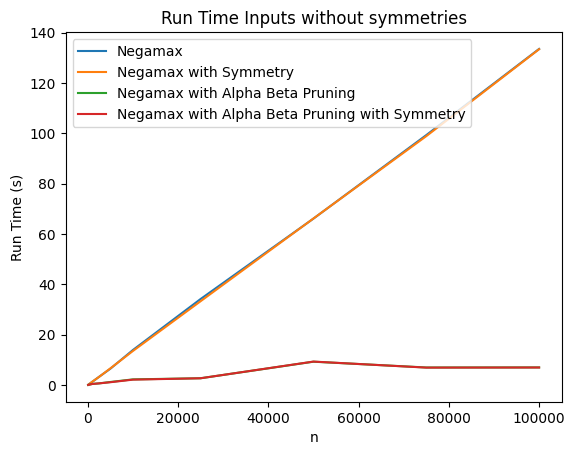

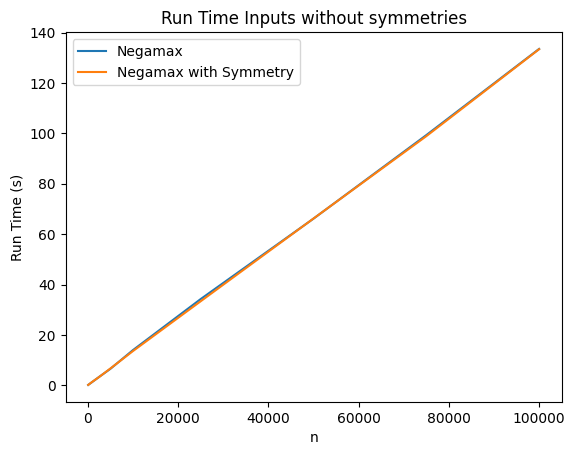

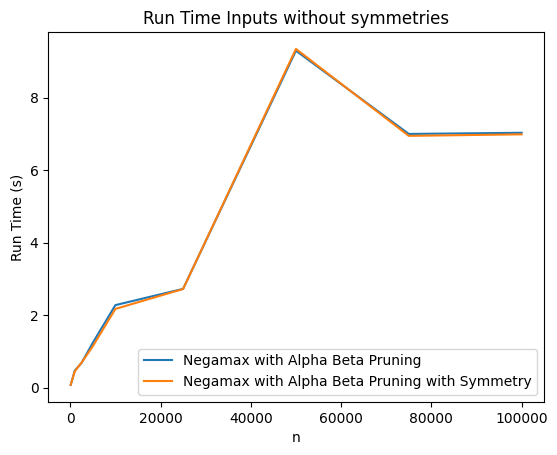

In [35]:
results_fixed_sleep = run_all_and_plot(n_list_no_symmetry, False)

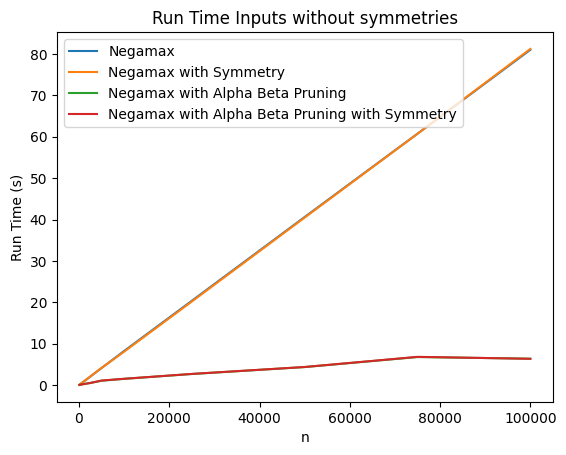

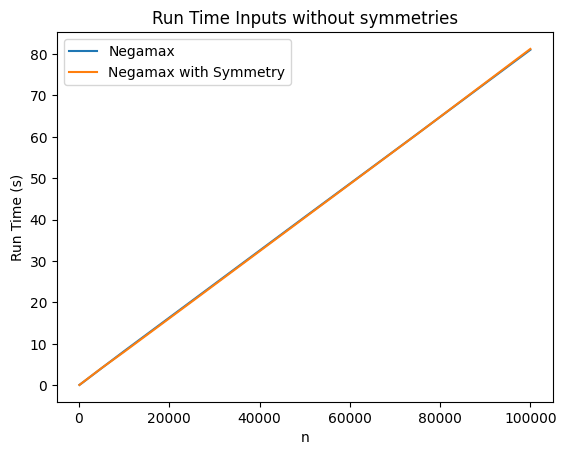

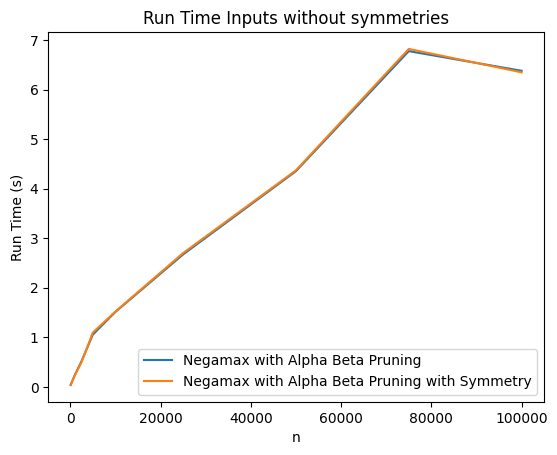

In [36]:
results_random_sleep = run_all_and_plot(n_list_no_symmetry, True)

#### Large inputs with symmetries 

In [37]:
n_list_for_symmetry = [25000, 50000, 75000, 100000, 150000]
k_division_list = [2, 4, 8, 10]  # We'll run with with random k from [0, n / k_division_list]

def run_all_with_symmetry(n_list, k_division_list, random_sleep):
    results = []
    for n in n_list:
        for k_division in k_division_list:
            k = n // k_division
            leaf_scores = generate_leaf_scores_with_symmetry(n, k)
            tree = construct_tree_from_leaf_scores(leaf_scores, random_sleep)
            deactivate_symmetry(tree)
            result = run_all(tree)
            results.append({
                "n": n,
                "k": k,
                "result_negamax": result["result_negamax"],
                "result_negamax_symmetry": result["result_negamax_symmetry"],
                "result_negamax_alpha_beta": result["result_negamax_alpha_beta"],
                "result_negamax_alpha_beta_symmetry": result["result_negamax_alpha_beta_symmetry"],
                "time_negamax": result["time_negamax"],
                "time_negamax_symmetry": result["time_negamax_symmetry"],
                "time_negamax_alpha_beta": result["time_negamax_alpha_beta"],
                "time_negamax_alpha_beta_symmetry": result["time_negamax_alpha_beta_symmetry"]
            })

    # Print graph for each n, each graph contains k values and for all algorithms
    for n in n_list:
        results_for_n = [result for result in results if result["n"] == n]
        k_values = [result["k"] for result in results_for_n]
        time_negamax = [result["time_negamax"] for result in results_for_n]
        time_negamax_symmetry = [result["time_negamax_symmetry"] for result in results_for_n]
        time_negamax_alpha_beta = [result["time_negamax_alpha_beta"] for result in results_for_n]
        time_negamax_alpha_beta_symmetry = [result["time_negamax_alpha_beta_symmetry"] for result in results_for_n]

        plot_graph(k_values, [time_negamax, time_negamax_symmetry, time_negamax_alpha_beta, time_negamax_alpha_beta_symmetry], labels, f"Large inputs with symmetries  - n = {n}", "k")

    return results

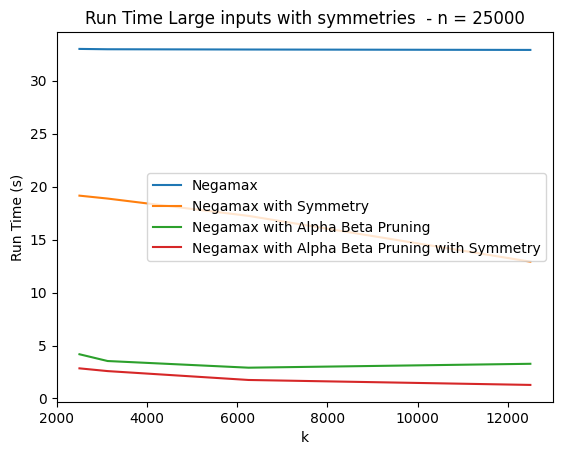

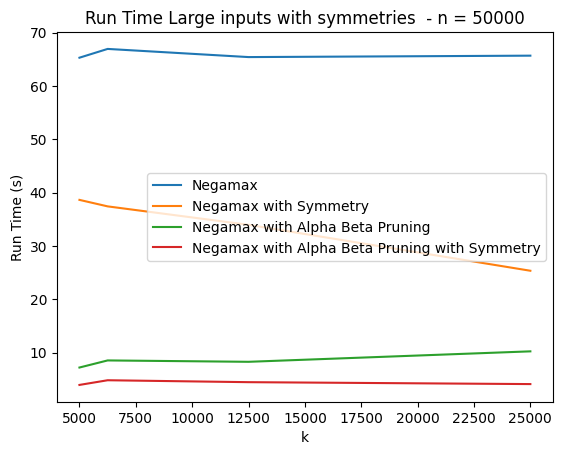

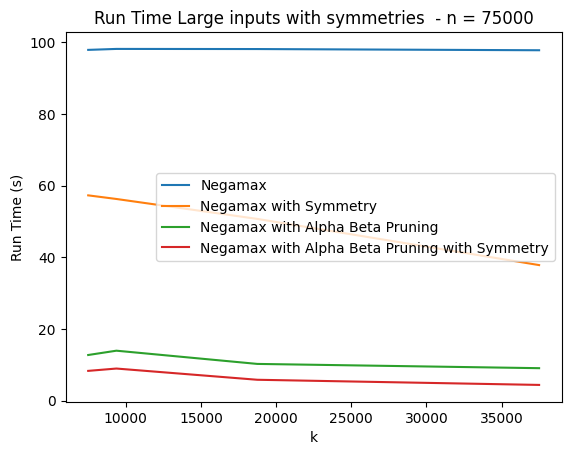

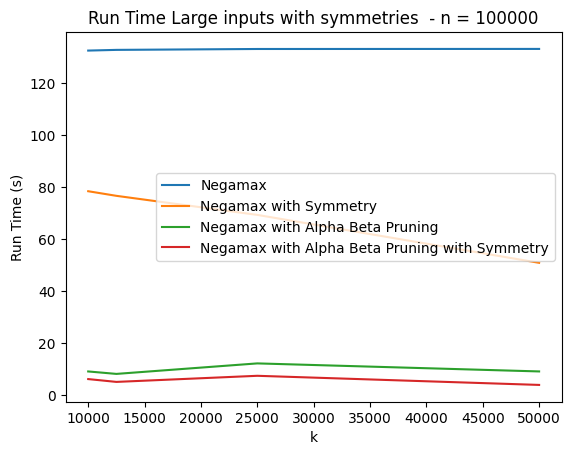

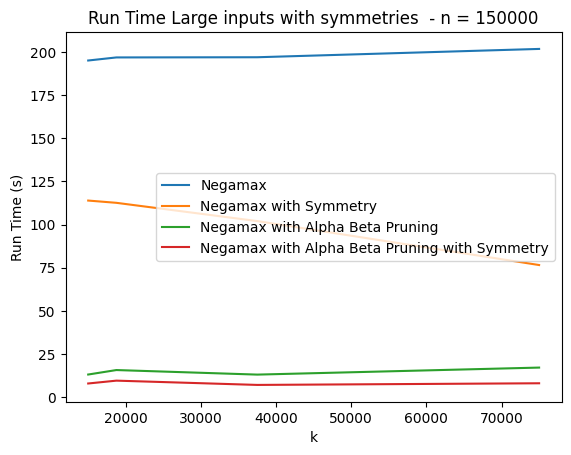

In [38]:
results_with_symmetry_fixed_sleep = run_all_with_symmetry(n_list_for_symmetry, k_division_list, False)

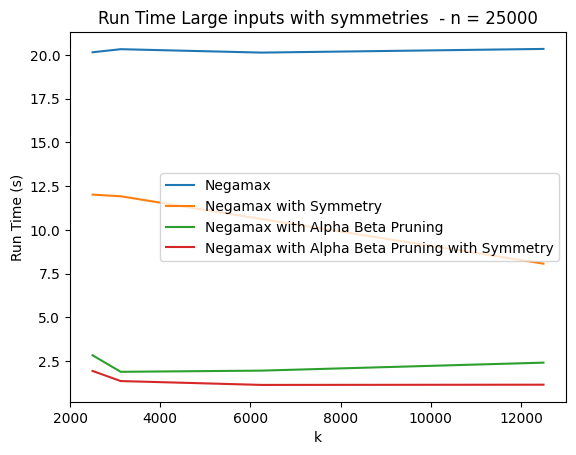

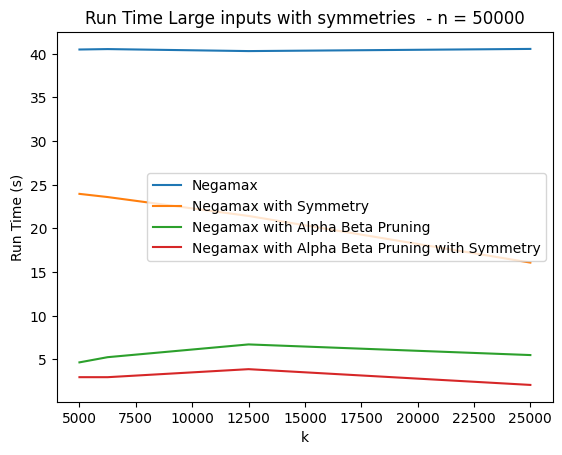

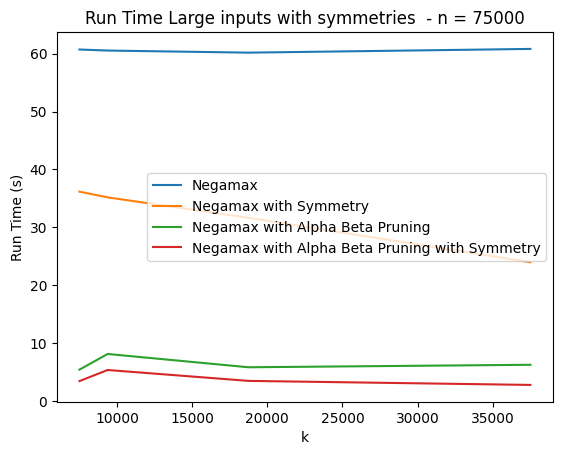

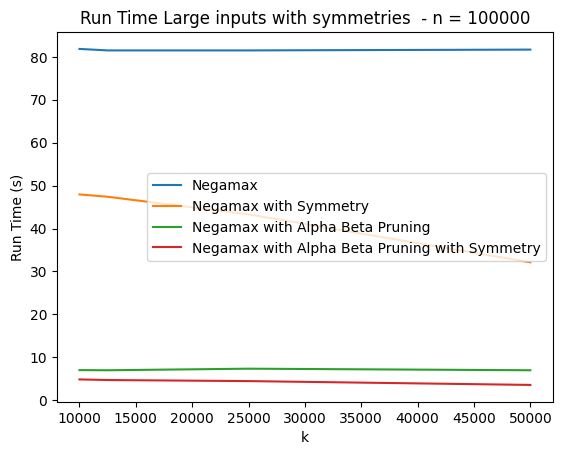

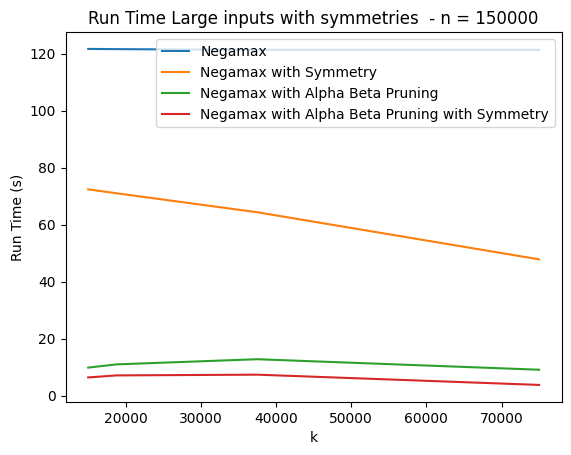

In [39]:
results_with_symmetry_random_sleep = run_all_with_symmetry(n_list_for_symmetry, k_division_list, True)

### Testing

In [20]:
def run_test_comparer(tree: list[TreeNode]):
    try:
        run_result = run_all(tree)
        result_negamax = run_result["result_negamax"]
        result_negamax_symmetry = run_result["result_negamax_symmetry"]
        result_negamax_alpha_beta = run_result["result_negamax_alpha_beta"]
        result_negamax_alpha_beta_symmetry = run_result["result_negamax_alpha_beta_symmetry"]

        if result_negamax != result_negamax_symmetry or result_negamax != result_negamax_alpha_beta or result_negamax != result_negamax_alpha_beta_symmetry:
            print("Results are not equal", result_negamax, result_negamax_symmetry, result_negamax_alpha_beta, result_negamax_alpha_beta_symmetry)
            return False
        return True
    except Exception as e:
        return False

def run_test():
    NUM_TEST = 100
    print("Running tests...")

    pass_count = 0
    for _ in range(NUM_TEST):
        leaf_scores = generate_leaf_scores_with_symmetry(10000, random.randint(0, 2500))
        # leaf_scores = generate_leaf_scores_with_symmetry(4, random.randint(0, 2))
        full_tree = construct_tree_from_leaf_scores(leaf_scores)
        deactivate_symmetry(full_tree)

        if run_test_comparer(full_tree):
            pass_count += 1
        else:
            print("--- Failed on", leaf_scores)

    print(f"Passed {pass_count} tests out of {NUM_TEST}")

def run_known_test_suite():
    suites = [
        # Normal test cases
        [-3, 7, 2, -1, -7, -3, 8, 4],
        [9, -6, -4, -3],
        [4, 8, 9, 3, 2, -2, 9, -1],
        [38, 75,  87, 9],
        # Error test cases
        [31, 34, 31, 93],   # Had diff result on symmetry
        [6, 93, 6, 93],     # Returned -inf for symmetry
        [42, 71, 1, 12],    # Crash because of inf on alpha-beta pruning with symmetry
        [27, 23, 17, 27]    # Symmetry produces wrong result
    ]

    pass_count = 0
    for leaf_scores in suites:
        full_tree = construct_tree_from_leaf_scores(leaf_scores)
        deactivate_symmetry(full_tree)
        if run_test_comparer(full_tree):
            pass_count += 1
        else:
            print("--- Fail on", leaf_scores)

    print(f"Passed {pass_count} tests out of {len(suites)}")


In [34]:
run_test()

Running tests...
Passed 100 tests out of 100


In [21]:
run_known_test_suite()

Passed 8 tests out of 8


### Sandbox

In [31]:
leaf_scores = generate_leaf_scores_with_symmetry(102400, random.randint(0, 51200))
# leaf_scores = generate_leaf_scores(4)
# print(leaf_scores)

full_tree = construct_tree_from_leaf_scores(leaf_scores)
deactivate_symmetry(full_tree)

# visualize_tree(full_tree)

run_all(full_tree)

{'result_negamax': 62797,
 'result_negamax_symmetry': 62797,
 'result_negamax_alpha_beta': 62797,
 'result_negamax_alpha_beta_symmetry': 62797,
 'time_negamax': 152.5466272830963,
 'time_negamax_symmetry': 76.43680763244629,
 'time_negamax_alpha_beta': 11.218692064285278,
 'time_negamax_alpha_beta_symmetry': 6.504548072814941}

In [30]:
leaf_scores = generate_leaf_scores_with_symmetry(102400, random.randint(0, 100))
# leaf_scores = generate_leaf_scores(4)
# print(leaf_scores)

full_tree = construct_tree_from_leaf_scores(leaf_scores)
deactivate_symmetry(full_tree)

# visualize_tree(full_tree)

run_all(full_tree)

{'result_negamax': 64923,
 'result_negamax_symmetry': 64923,
 'result_negamax_alpha_beta': 64923,
 'result_negamax_alpha_beta_symmetry': 64923,
 'time_negamax': 151.58992838859558,
 'time_negamax_symmetry': 95.75952935218811,
 'time_negamax_alpha_beta': 10.038084745407104,
 'time_negamax_alpha_beta_symmetry': 6.661450386047363}

In [11]:
leaf_scores = generate_leaf_scores_with_symmetry(10240000, random.randint(0, 5120000))
# leaf_scores = generate_leaf_scores(4)
# print(leaf_scores)

full_tree = construct_tree_from_leaf_scores(leaf_scores)
deactivate_symmetry(full_tree)

# visualize_tree(full_tree)

run_all(full_tree)

{'result_negamax': 62,
 'result_negamax_symmetry': 62,
 'result_negamax_alpha_beta': 62,
 'result_negamax_alpha_beta_symmetry': 62,
 'time_negamax': 22.305155277252197,
 'time_negamax_symmetry': 20.857252597808838,
 'time_negamax_alpha_beta': 0.6743314266204834,
 'time_negamax_alpha_beta_symmetry': 0.6314482688903809}